# Load needed libraries

In [1]:
#Basic data handling and plotting
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sbn
import os

In [2]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [3]:
#Versions for the loaded packages
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==1.2.4
numpy==1.21.2
matplotlib==3.4.1
seaborn==0.11.1
statsmodels.api==0.12.2


# Read in dataset

In [4]:
path = 'G:/My Drive/MKA/Papers/Greco/Katie/20201210_Science_submission/20210928_Rebuttal/Data'
df = pd.read_csv(os.path.join(path, 'Tape strip_wt vs Cdkn1b_basal_density.csv'), sep = ';', index_col = 0, header = [0,1])
df.head()

Genotype:,Wildtype,Unnamed: 2_level_0,Unnamed: 3_level_0,Cdkn1b,Unnamed: 5_level_0,Unnamed: 6_level_0
,Rep1,Rep2,Rep3,Rep1,Rep2,Rep3
0h,"100,0","100,0","100,0","100,0","100,0","100,0"
12h,"79,3","78,0","90,0","79,2","75,4","71,1"
24h,"75,8","72,2","94,1","65,1","72,6","64,8"
48h,"97,6","93,1","98,5","73,3","79,5","51,7"
72h,"94,6","88,0","104,4","99,2","84,8","94,9"


## Convert dataset to be more suitable for analysis

In [5]:
df.index.name = 'Time' #Give index column a name
df.columns = pd.MultiIndex.from_product([['Wildtype', 'Cdkn1b'], ['Rep1','Rep2','Rep3']]) #Make column names nicer
df = df.applymap(lambda x: x.replace(',', '.')).astype(float) #Use '.' instead of ',' in numbers and convert to float 
df

Wildtype               Cdkn1b              
         Rep1   Rep2   Rep3   Rep1   Rep2   Rep3
Time                                            
0h      100.0  100.0  100.0  100.0  100.0  100.0
12h      79.3   78.0   90.0   79.2   75.4   71.1
24h      75.8   72.2   94.1   65.1   72.6   64.8
48h      97.6   93.1   98.5   73.3   79.5   51.7
72h      94.6   88.0  104.4   99.2   84.8   94.9
96h     104.8   99.9   96.7  102.7   83.0  115.1

In [6]:
#Convert dataframe to long-form
df = df.reset_index().melt(id_vars = 'Time', value_name = 'Proportion', var_name = ['Genotype', 'Replicate'])
#Make new column for number of days - remove 'h' and divide by 24
df['Days'] = df['Time'].str.strip('h').astype(int)/24
df = df.sort_values(by = 'Days') #Sort values by Days from lowest to highest
df.head(10)

,Time,Genotype,Replicate,Proportion,Days
0,0h,Wildtype,Rep1,100.0,0.0
24,0h,Cdkn1b,Rep2,100.0,0.0
18,0h,Cdkn1b,Rep1,100.0,0.0
12,0h,Wildtype,Rep3,100.0,0.0
6,0h,Wildtype,Rep2,100.0,0.0
30,0h,Cdkn1b,Rep3,100.0,0.0
31,12h,Cdkn1b,Rep3,71.1,0.5
7,12h,Wildtype,Rep2,78.0,0.5
19,12h,Cdkn1b,Rep1,79.2,0.5
25,12h,Cdkn1b,Rep2,75.4,0.5


## Plot data to check that it makes sense

[None, None]

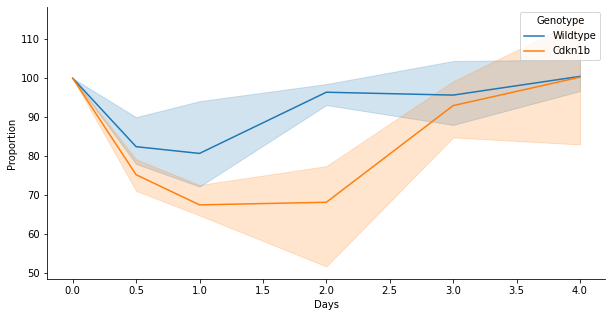

In [7]:
fig, ax = plt.subplots(figsize = (10, 5))
sbn.lineplot(data = df, x = 'Days', y = 'Proportion', hue = 'Genotype', ax = ax)
[ax.spines[spine].set_visible(False) for spine in ['top', 'right']]

[None, None]

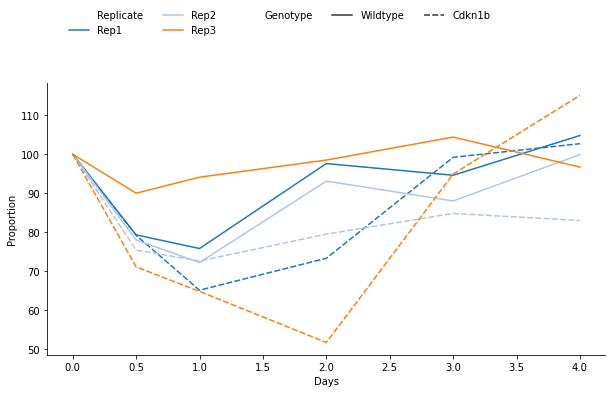

In [8]:
fig, ax = plt.subplots(figsize = (10, 5))
ax = sbn.lineplot(data = df, x = 'Days', y = 'Proportion', hue = 'Replicate', style = 'Genotype', palette = 'tab20')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles = handles, labels = labels, ncol = 5, bbox_to_anchor = [0.81, 1.3], frameon = False, title = '')
[ax.spines[spine].set_visible(False) for spine in ['top', 'right']]

# Analyze differences

## Find a good polynomial degree for fitting model

Text(0.5, 0, 'Degree')

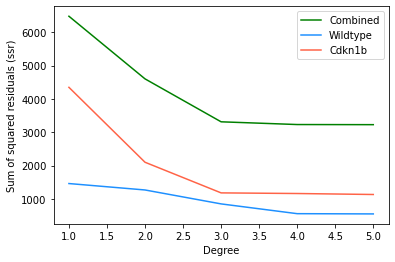

In [9]:
#Plot residuals between data and the fitting model depending on the polynomial degree
max_deg = 6 #The maximum degree for fit

x = df['Days'].values
y = df['Proportion'].values
deg = np.arange(1, max_deg)
res = []
for d in deg:
    z, residuals, rank, singular_values, rcond = np.polyfit(x, y, d, full = True)
    res.append(residuals)
plt.plot(deg, res, c = 'g', ls = '-')

for ix, g in enumerate(df['Genotype'].unique()):
    x = df[df['Genotype']==g]['Days'].values
    y = df[df['Genotype']==g]['Proportion'].values
    deg = np.arange(1, max_deg)
    res = []
    for d in deg:
        z, residuals, rank, singular_values, rcond = np.polyfit(x, y, d, full = True)
        res.append(residuals)

    plt.plot(deg, res, c = ['dodgerblue','tomato'][ix], ls = '-')
plt.legend(labels = ['Combined', 'Wildtype', 'Cdkn1b'])
plt.ylabel('Sum of squared residuals (ssr)')
plt.xlabel('Degree')
#Both genotypes show an elbow at degree 3 - good choice for a fit

Wildtype: y = -2.907x^3 + 19.641x^2 + -31.649x + 97.476
Cdkn1b: y = -4.311x^3 + 33.264x^2 + -63.950x + 100.174


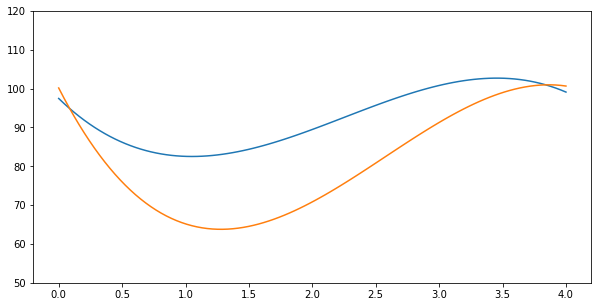

In [10]:
#Get the formula for the fitted model
deg = 3
fig, ax = plt.subplots(figsize = (10, 5))

xp = np.linspace(0,4,100)

for ix, g in enumerate(df['Genotype'].unique()):
    x = df[df['Genotype']==g]['Days'].values
    y = df[df['Genotype']==g]['Proportion'].values
    z = np.polyfit(x,y,deg)
    p = np.poly1d(z)
    ax.plot(xp, p(xp))
    ax.set_ylim([50,120])
    print(f'{g}: y = {z[0]:.3f}x^3 + {z[1]:.3f}x^2 + {z[2]:.3f}x + {z[3]:.3f}')

# Calculate linear models and statistical difference

### Plot the fitted model for full data and separated genotypes

Add quadratic model for comparison

C:\Users\karlan\AppData\Local\Continuum\anaconda3\envs\anna\lib\site-packages\seaborn\algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))


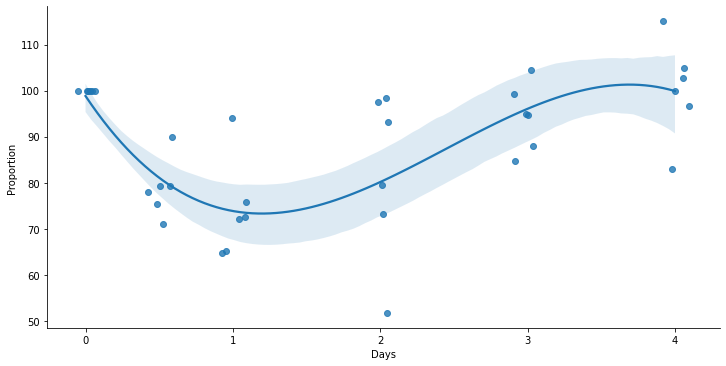

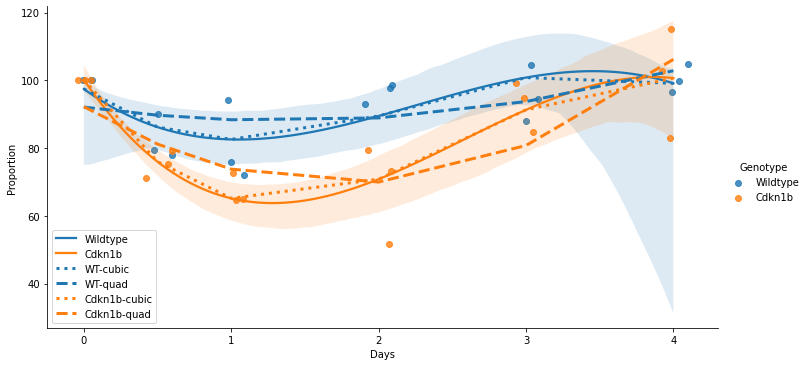

In [14]:
cmap = sbn.color_palette(palette = 'tab10', n_colors = 2)

y = 'Proportion'
ax = sbn.lmplot(data = df, x = 'Days', y = y, hue = None, order = 3, x_jitter = 0.1, robust = False, 
                x_ci = 95, height = 5, aspect = 2)
ax = sbn.lmplot(data = df, x = 'Days', y = y, hue = 'Genotype', order = 3, x_jitter = 0.1, robust = False, 
                x_ci = 'sd', height = 5, aspect = 2, n_boot = 1000)

xp = np.linspace(0,4,100)
for ix, g in enumerate(df['Genotype'].unique()):
    x = df[df['Genotype']==g]['Days'].values
    y = df[df['Genotype']==g]['Proportion'].values
    z = np.polyfit(x,y,3)
    p = np.poly1d(z)
    plt.plot(x, p(x), ls = ':', lw = 3, c = cmap[ix])
    
    z = np.polyfit(x,y,2)
    p = np.poly1d(z)
    plt.plot(x, p(x), ls = '--', lw = 3, c = cmap[ix])

plt.legend(labels = ['Wildtype','Cdkn1b', 'WT-cubic', 'WT-quad','Cdkn1b-cubic', 'Cdkn1b-quad'])

### Make models using Ordinary Least Squares (OLS) from statsmodels

In [15]:
#First model explains 'Proportion' as a function of 'Days' passed, without separating Genotype
pm0 = ols('Proportion ~ Days + I(Days**2) + I(Days**3)', data = df).fit()

#Second model explains 'Proportion' as a function of 'Days' and 'Genotype'
pm1 = ols('Proportion ~ (Days + I(Days**2) + I(Days**3)) * Genotype', data = df).fit()

In [16]:
#Use anova (from statsmodels)
anova_lm(pm0, pm1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,32.0,3311.326587,0.0,NaN,NaN,NaN
1,28.0,2028.711532,4.0,1282.615055,4.42562,0.006742


Explanation of the output

df_resid:
Degrees of freedom of residuals in models.

ssr:
Sum of squares of residuals in models.

df_diff:
Degrees of freedom difference from previous model in args

ss_dff:
Difference in ssr from previous model in args

F:
F statistic comparing to previous model in args

PR(>F):
P-value for significance comparing to previous model in args